In [30]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

#Installing dependencies
!pip install music21
!apt-get install -y lilypond

/kaggle/input/music-generated-lstm/Melody_Snippet_Cleaned.wav
/kaggle/input/music-generated-lstm/Melody_Generated 2.wav
/kaggle/input/music-generated-lstm/Melody_Generated_1.wav
/kaggle/input/music-generated-lstm/Corpus_Snippet.wav
/kaggle/input/classical-music-midi/brahms/br_im2.mid
/kaggle/input/classical-music-midi/brahms/br_im5.mid
/kaggle/input/classical-music-midi/brahms/BR_IM6.MID
/kaggle/input/classical-music-midi/brahms/brahms_opus1_4.mid
/kaggle/input/classical-music-midi/brahms/brahms_opus117_2.mid
/kaggle/input/classical-music-midi/brahms/brahms_opus1_2.mid
/kaggle/input/classical-music-midi/brahms/brahms_opus1_1.mid
/kaggle/input/classical-music-midi/brahms/brahms_opus1_3.mid
/kaggle/input/classical-music-midi/brahms/br_rhap.mid
/kaggle/input/classical-music-midi/brahms/brahms_opus117_1.mid
/kaggle/input/classical-music-midi/granados/gra_esp_4.mid
/kaggle/input/classical-music-midi/granados/gra_esp_2.mid
/kaggle/input/classical-music-midi/granados/gra_esp_3.mid
/kaggle/inp

In [31]:
#Importing Libraries
import tensorflow 
import numpy as np 
import pandas as pd 
from collections import Counter
import os
import random
import IPython
from IPython.display import Image, Audio
import music21
from music21 import *
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import tensorflow.keras.backend as K
from tensorflow.keras.optimizers import Adamax
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline
import sys
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter("ignore")
np.random.seed(42)

In [32]:
!pip install music21

In [33]:
#Loading the list of chopin's midi files as stream 
filepath = "../input/classical-music-midi/chopin/"
#Getting midi files
all_midis= []
for i in os.listdir(filepath):
    if i.endswith(".mid"):
        tr = filepath+i
        midi = converter.parse(tr)
        all_midis.append(midi)

In [34]:
#Helping function        
def extract_notes(file):
    notes = []
    pick = None
    for j in file:
        songs = instrument.partitionByInstrument(j)
        for part in songs.parts:
            pick = part.recurse()
            for element in pick:
                if isinstance(element, note.Note):
                    notes.append(str(element.pitch))
                elif isinstance(element, chord.Chord):
                    notes.append(".".join(str(n) for n in element.normalOrder))

    return notes
#Getting the list of notes as Corpus
Corpus= extract_notes(all_midis)
print("Total notes in all the Chopin midis in the dataset:", len(Corpus))

Total notes in all the Chopin midis in the dataset: 57887


In [35]:
print("First fifty values in the Corpus:", Corpus[:50])

First fifty values in the Corpus: ['6.10.1', 'F#2', 'F3', 'G#3', 'F#3', 'B-3', 'C#3', '6.10.1', 'F#2', 'F3', 'G#3', 'F#3', 'B-3', 'C#3', '6.10.1', 'F#2', 'F3', 'G#3', 'F#3', 'B-3', 'C#3', 'F4', 'B4', 'C#2', 'G3', 'B-3', 'G#3', 'G#4', 'B3', 'C#3', '6.10.1', 'F#2', 'F3', 'G#3', 'F#3', 'B-3', 'C#3', 'C#4', '6.10', 'F#2', 'F3', 'G#3', 'F#3', '6.10', 'B-3', 'C#3', 'C#4', '6.10', 'F#2', 'F3']


In [36]:
def show(music):
    display(Image(str(music.write("lily.png"))))
    
def chords_n_notes(Snippet):
    Melody = []
    offset = 0 #Incremental
    for i in Snippet:
        #If it is chord
        if ("." in i or i.isdigit()):
            chord_notes = i.split(".") #Seperating the notes in chord
            notes = [] 
            for j in chord_notes:
                inst_note=int(j)
                note_snip = note.Note(inst_note)            
                notes.append(note_snip)
                chord_snip = chord.Chord(notes)
                chord_snip.offset = offset
                Melody.append(chord_snip)
        # pattern is a note
        else: 
            note_snip = note.Note(i)
            note_snip.offset = offset
            Melody.append(note_snip)
        # increase offset each iteration so that notes do not stack
        offset += 1
    Melody_midi = stream.Stream(Melody)   
    return Melody_midi

Melody_Snippet = chords_n_notes(Corpus[:100])
# show(Melody_Snippet)

In [ ]:
#to play audio or corpus
print("Sample Audio From Data")
IPython.display.Audio("../input/music-generated-lstm/Corpus_Snippet.wav") 

Sample Audio From Data


**Examine all the notes in the Corpus** 

In [37]:
#Creating a count dictionary
count_num = Counter(Corpus)
print("Total unique notes in the Corpus:", len(count_num))

Total unique notes in the Corpus: 397


In [38]:
#Exploring the notes dictionary
Notes = list(count_num.keys())
Recurrence = list(count_num.values())
#Average recurrenc for a note in Corpus
def Average(lst):
    return sum(lst) / len(lst)
print("Average recurrenc for a note in Corpus:", Average(Recurrence))
print("Most frequent note in Corpus appeared:", max(Recurrence), "times")
print("Least frequent note in Corpus appeared:", min(Recurrence), "time")

Average recurrenc for a note in Corpus: 145.8110831234257
Most frequent note in Corpus appeared: 1627 times
Least frequent note in Corpus appeared: 1 time


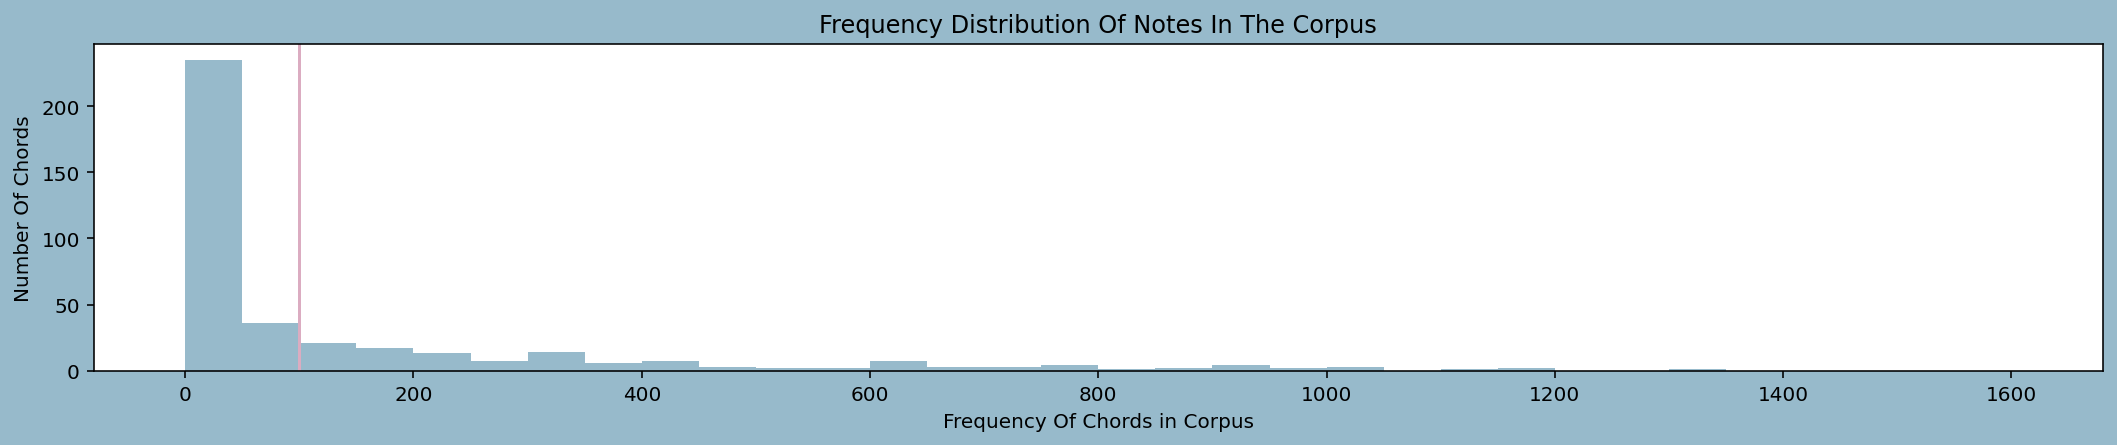

In [39]:
# Plotting the distribution of Notes
plt.figure(figsize=(18,3),facecolor="#97BACB")
bins = np.arange(0,(max(Recurrence)), 50) 
plt.hist(Recurrence, bins=bins, color="#97BACB")
plt.axvline(x=100,color="#DBACC1")
plt.title("Frequency Distribution Of Notes In The Corpus")
plt.xlabel("Frequency Of Chords in Corpus")
plt.ylabel("Number Of Chords")
plt.show()

In [40]:
#Getting a list of rare chords
rare_note = []
for index, (key, value) in enumerate(count_num.items()):
    if value < 100:
        m =  key
        rare_note.append(m)
        
print("Total number of notes that occur less than 100 times:", len(rare_note))

Total number of notes that occur less than 100 times: 271


In [41]:
#Eleminating the rare notes
for element in Corpus:
    if element in rare_note:
        Corpus.remove(element)
def show(music):
    display(Image(str(music.write("lily.png"))))
    
def chords_n_notes(Snippet):
    Melody = []
    offset = 0 #Incremental
    for i in Snippet:
        #If it is chord
        if ("." in i or i.isdigit()):
            chord_notes = i.split(".") #Seperating the notes in chord
            notes = [] 
            for j in chord_notes:
                inst_note=int(j)
                note_snip = note.Note(inst_note)            
                notes.append(note_snip)
                chord_snip = chord.Chord(notes)
                chord_snip.offset = offset
                Melody.append(chord_snip)
        # pattern is a note
        else: 
            note_snip = note.Note(i)
            note_snip.offset = offset
            Melody.append(note_snip)
        # increase offset each iteration so that notes do not stack
        offset += 1
    Melody_midi = stream.Stream(Melody)   
    return Melody_midi

Melody_Snippet = chords_n_notes(Corpus[:100])
# show(Melody_Snippet)
print("Length of Corpus after elemination the rare notes:", len(Corpus))

Length of Corpus after elemination the rare notes: 53712


In [42]:
# Storing all the unique characters present in my corpus to bult a mapping dic. 
symb = sorted(list(set(Corpus)))

L_corpus = len(Corpus) #length of corpus
L_symb = len(symb) #length of total unique characters

#Building dictionary to access the vocabulary from indices and vice versa
mapping = dict((c, i) for i, c in enumerate(symb))
reverse_mapping = dict((i, c) for i, c in enumerate(symb))

print("Total number of characters:", L_corpus)
print("Number of unique characters:", L_symb)

Total number of characters: 53712
Number of unique characters: 266


**Encoding and Splitting the Corpus as Labels and Targets**

In [43]:
#Splitting the Corpus in equal length of strings and output target
length = 40
features = []
targets = []
for i in range(0, L_corpus - length, 1):
    feature = Corpus[i:i + length]
    target = Corpus[i + length]
    features.append([mapping[j] for j in feature])
    targets.append(mapping[target])
    
    
L_datapoints = len(targets)
print("Total number of sequences in the Corpus:", L_datapoints)

Total number of sequences in the Corpus: 53672


In [44]:
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Lambda, Dropout
from tensorflow.keras import backend as K
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.optimizers import Adamax
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import RepeatVector

import tensorflow as tf


**Splitting Train and Seed datasets**

In [45]:
def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

# Network parameters
input_shape = (40, 1) # Adjust based on your feature set
intermediate_dim = 512
latent_dim = 2
batch_size = 256
epochs = 200

# Encoder model
inputs = Input(shape=input_shape, name='encoder_input')
x = LSTM(intermediate_dim, return_sequences=True)(inputs)
x = Dropout(0.1)(x)
x = LSTM(intermediate_dim)(x)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()

# Decoder model
# Decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(intermediate_dim, activation='relu')(latent_inputs)
x = Dropout(0.1)(x)
x = RepeatVector(input_shape[0])(x)  # Repeat the vector to match the input sequence length
x = LSTM(intermediate_dim, return_sequences=True)(x)
x = LSTM(input_shape[1], return_sequences=True)(x)  # Use input_shape[1] to match the feature dimension
outputs = Dense(input_shape[1], activation='sigmoid')(x)  # Match output dimension to feature dimension
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()


# VAE model
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae_mlp')


Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 40, 1)]      0                                            
__________________________________________________________________________________________________
lstm_4 (LSTM)                   (None, 40, 512)      1052672     encoder_input[0][0]              
__________________________________________________________________________________________________
dropout_2 (Dropout)             (None, 40, 512)      0           lstm_4[0][0]                     
__________________________________________________________________________________________________
lstm_5 (LSTM)                   (None, 512)          2099200     dropout_2[0][0]                  
____________________________________________________________________________________________


I will be employing an LSTM for this project.

**Following steps are involved in the model building**

* Initialising the Model
* Defining by adding layers
* Compiling the Model
* Training the Model

**Building the Model**

In [46]:
reconstruction_loss = binary_crossentropy(K.flatten(inputs), K.flatten(outputs))
reconstruction_loss *= input_shape[0] * input_shape[1]
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer=Adamax(learning_rate=0.01))


In [52]:
X = (np.reshape(features, (L_datapoints, length, 1)))/ float(L_symb)
# one hot encode the output variable
y = tensorflow.keras.utils.to_categorical(targets) 

In [53]:
X_train, X_seed, y_train, y_seed = train_test_split(X, y, test_size=0.2, random_state=42)
history=vae.fit(X_train, X_train, epochs=epochs, batch_size=batch_size, validation_data=(X_seed, X_seed))


Epoch 1/200
168/168 [==============================] - 34s 127ms/step - loss: 28.0221 - val_loss: 24.8109
Epoch 2/200
168/168 [==============================] - 20s 117ms/step - loss: 24.8548 - val_loss: 24.8104
Epoch 3/200
168/168 [==============================] - 20s 117ms/step - loss: 24.8463 - val_loss: 24.8107
Epoch 4/200
168/168 [==============================] - 20s 117ms/step - loss: 24.8890 - val_loss: 24.8103
Epoch 5/200
168/168 [==============================] - 20s 117ms/step - loss: 24.8124 - val_loss: 24.8103
Epoch 6/200
168/168 [==============================] - 20s 117ms/step - loss: 24.8321 - val_loss: 24.8107
Epoch 7/200
168/168 [==============================] - 20s 117ms/step - loss: 24.8360 - val_loss: 24.8102
Epoch 8/200
168/168 [==============================] - 20s 117ms/step - loss: 24.8178 - val_loss: 24.8114
Epoch 9/200
168/168 [==============================] - 20s 117ms/step - loss: 24.8065 - val_loss: 24.8102
Epoch 10/200
168/168 [========================

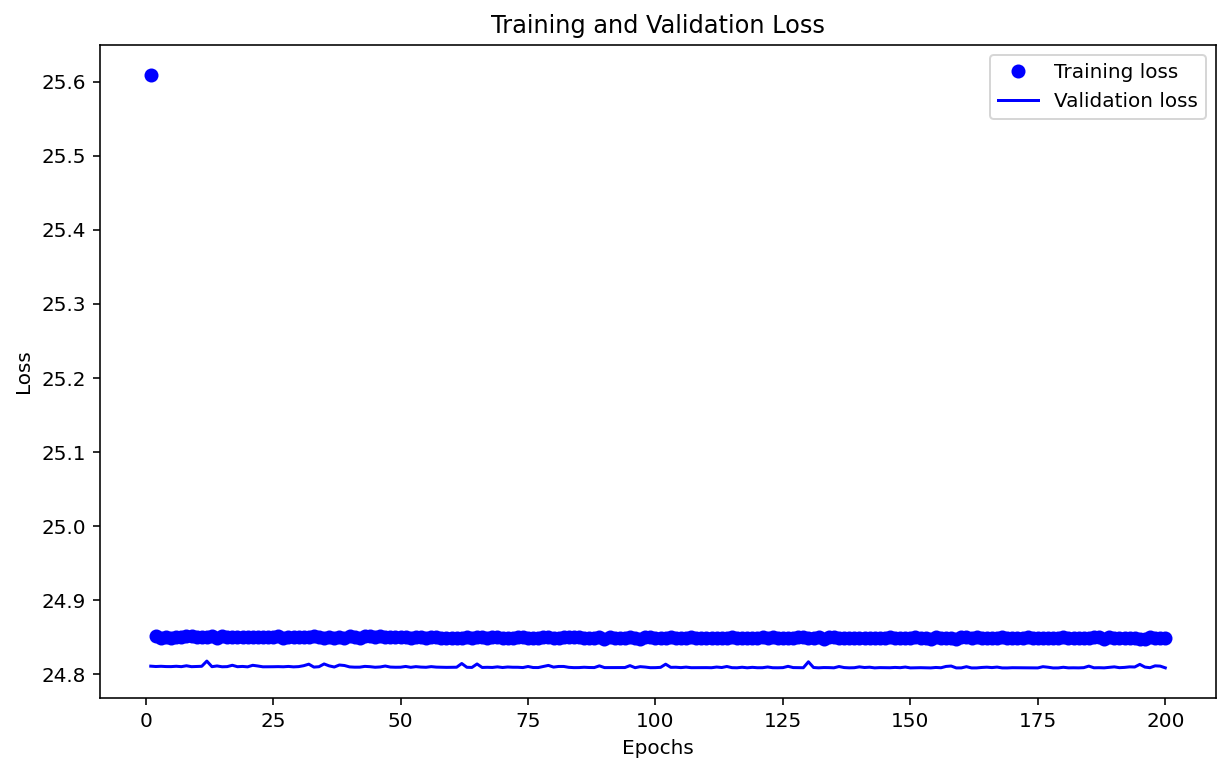

In [57]:
import matplotlib.pyplot as plt

# Extracting values from the history object
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

# Plotting the training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(epochs, loss, 'bo', label='Training loss')  # 'bo' gives blue dot
plt.plot(epochs, val_loss, 'b', label='Validation loss')  # 'b' gives solid blue line
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()
